In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t, norm, binom, rankdata
from sklearn.linear_model import LinearRegression

# Enter 2 columns of B (before), A (after)
dt = {'Selective Reduction': [32,40,11,47,32,35,32,63,50,60,38,46,20,31,62,52,77,23,30,70,41,53,19,31,48], 
      'Permanganate':        [39,47,11,43,42,30,43,98,86,79,33,45,22,30,60,53,85,21,33,57,43,49,20,35,40]}

df = pd.DataFrame(dt)
df.drop(index=df[df['Selective Reduction']==df['Permanganate']].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df['Difference'] = df.apply(lambda X: X['Permanganate'] - X['Selective Reduction'], axis=1)
df['Sign'] = df['Difference'].apply(lambda d: 1 if d > 0 else -1)
df['Signed Rank'] = rankdata(abs(df.Difference)) * df.Sign
df[['Selective Reduction', 'Permanganate', 'Difference']] = df[['Selective Reduction', 'Permanganate', 'Difference']] / 100
df

,Selective Reduction,Permanganate,Difference,Sign,Signed Rank
0,0.32,0.39,0.07,1,15.5
1,0.40,0.47,0.07,1,15.5
2,0.47,0.43,-0.04,-1,-11.0
3,0.32,0.42,0.10,1,19.0
4,0.35,0.30,-0.05,-1,-13.5
5,0.32,0.43,0.11,1,20.0
6,0.63,0.98,0.35,1,23.0
7,0.50,0.86,0.36,1,24.0
8,0.60,0.79,0.19,1,22.0
9,0.38,0.33,-0.05,-1,-13.5


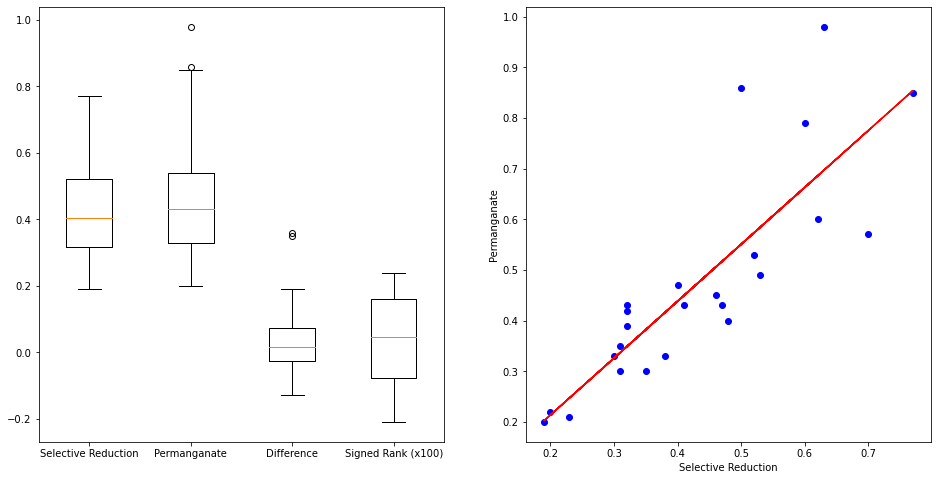

In [2]:
w, h = 2, 1
fig, axes = plt.subplots(h, w, figsize=(16, 8))

axes[0].boxplot([df['Selective Reduction'], df['Permanganate'], df['Difference'], df['Signed Rank']/100],
                labels=['Selective Reduction', 'Permanganate', 'Difference', 'Signed Rank (x100)'])
axes[1].scatter(df['Selective Reduction'], df['Permanganate'], color='b')
axes[1].set_xlabel('Selective Reduction')
axes[1].set_ylabel('Permanganate')

model = LinearRegression()
model.fit(df['Selective Reduction'].values.reshape(-1,1), df['Permanganate'].values.reshape(-1,1))
Y = model.predict(df['Selective Reduction'].values.reshape(-1,1))
axes[1].plot(df['Selective Reduction'], Y, color='r')

plt.show()

#### 1. Difference Test

In [3]:
# The mean of Diff is normally distributed, hence
mean = df['Difference'].mean()
std_mean = df['Difference'].std() / (len(df))**0.5
round(mean, 3), round(std_mean, 3)

(0.042, 0.024)

In [4]:
# Set significant level alpha, degree of freedoms, one tail or two tails.
alpha, ddof = 0.05, len(df) - 1
two_tails = True

# Compute the t statistic value
if two_tails:
    t_alpha = t.ppf(1 - alpha/2, ddof) 
else:
    t_alpha = t.ppf(1 - alpha, ddof) 

round(t_alpha, 3)

2.069

In [5]:
# Compute the (1 - alpha) * 100% confidence interval
ci = (mean - t_alpha * std_mean, mean + t_alpha * std_mean)
round(ci[0], 3), round(ci[1], 3)

(-0.008, 0.092)

In [6]:
# Asumme H0 is true, then D = 0, hence the t statistic:
t_null = abs(mean) / std_mean
round(t_null, 3), ddof

(1.748, 23)

In [7]:
# Evaluate the rejection of H0
if t_null > t_alpha:
    print('The test statistic is statistically significant. H0 should be rejected!')
else:
    print('The test statistic is not statistically significant. H0 cannot be rejected!')

The test statistic is not statistically significant. H0 cannot be rejected!


In [8]:
p_value = 1 - t.cdf(t_null, ddof)

if two_tails:
    print(round(2 * p_value, 3))
else:
    print(round(p_value, 3))

0.094


In [9]:
# Other way to compute the p_value using the survival function of stats
p_value = t.sf(t_null, ddof)

if two_tails:
    print(round(2 * p_value, 3))
else:
    print(round(p_value, 3))

0.094


#### 2. Signed Rank Test

In [10]:
# Compute the mean and std of the rank
n = len(df)
mean = n * (n + 1) / 4
std_ = (n * (n + 1) * (2 * n + 1) / 24)**0.5
round(mean, 3), round(std_, 3)

(150.0, 35.0)

In [11]:
# Set significant level alpha, one tail or two tails.
alpha = 0.05
two_tails = True

# Compute the Z statistic value
if two_tails:
    Z_alpha = norm.ppf(1 - alpha/2) 
else:
    Z_alpha = norm.ppf(1 - alpha) 

round(Z_alpha, 3)

1.96

In [12]:
# Compute the (1 - alpha) * 100% confidence interval
ci = (mean - Z_alpha * std_, mean + Z_alpha * std_)
round(ci[0], 3), round(ci[1], 3)

(81.401, 218.599)

In [13]:
# Asumme H0 is true, then Rank = 0, hence the Z statistic:
negative_sum = df['Signed Rank'][df['Signed Rank'] < 0].sum() * (-1)
Z_null = abs(negative_sum - mean) / std_
negative_sum, round(Z_null, 3)

(105.5, 1.271)

In [14]:
# Evaluate the rejection of H0
if Z_null > Z_alpha:
    print('The test statistic is statistically significant. H0 should be rejected!')
else:
    print('The test statistic is not statistically significant. H0 cannot be rejected!')

The test statistic is not statistically significant. H0 cannot be rejected!


In [15]:
p_value = 1 - norm.cdf(Z_null)

if two_tails:
    print(round(2 * p_value, 3))
else:
    print(round(p_value, 3))

0.204


In [16]:
# Other way to compute the p_value using the survival function of stats
p_value = norm.sf(Z_null)

if two_tails:
    print(round(2 * p_value, 3))
else:
    print(round(p_value, 3))

0.204


#### 3. Sign Test

In [17]:
n = len(df)
two_tail = True
len(df[df.Sign > 0]), len(df[df.Sign < 0]), n

(14, 10, 24)

In [18]:
# Compute the test statistic = min (# positive, # negative)
n, p = len(df), 0.5
k = min(len(df[df.Sign > 0]), len(df[df.Sign < 0]))
k, n, p

(10, 24, 0.5)

In [19]:
# Compute the p-value = P(x <= k)
p_value = binom.cdf(k, n, p)
if two_tails:
    p_value *= 2
round(p_value, 3)

0.541

In [20]:
alpha = 0.05

# Evaluate the rejection of H0
if p_value < alpha:
    print('The test statistic is statistically significant. H0 should be rejected!')
else:
    print('The test statistic is not statistically significant. H0 cannot be rejected!')

The test statistic is not statistically significant. H0 cannot be rejected!
